In [61]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from model.AlphaPEM import AlphaPEM
import numpy as np
import pandas as pd

data = pd.read_pickle('../data/raw/PDP_20_default.pkl')


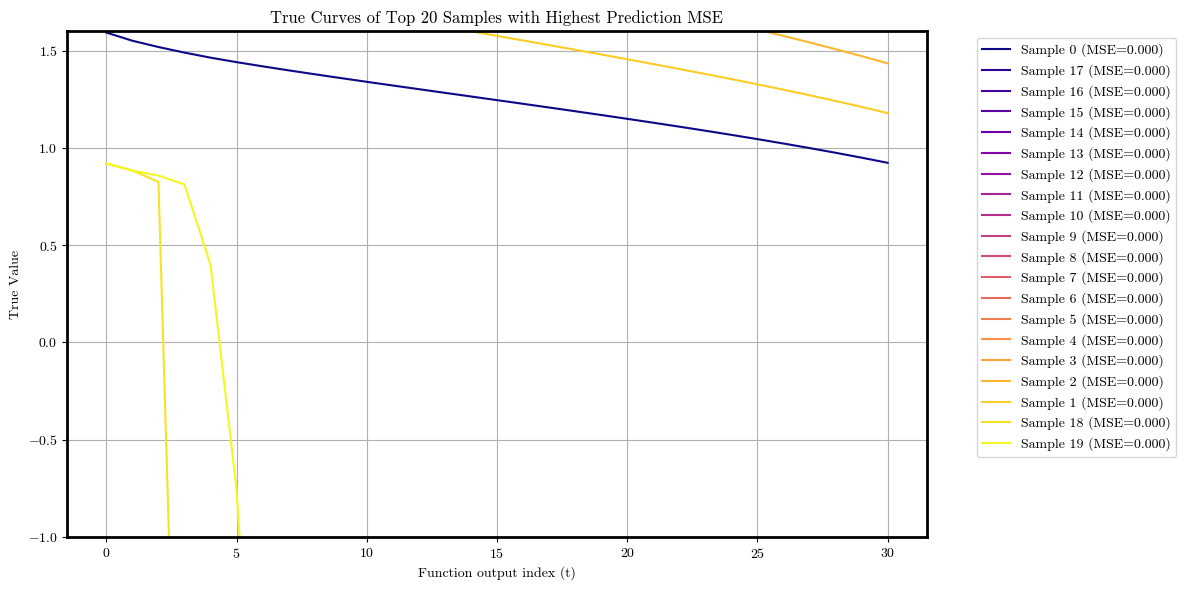

In [123]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_true_curves(Y_true, Y_pred, top_k=10):
    """
    Plot only the true curves of the top_k samples with highest MSE.
    
    Args:
        Y_true (np.array): True function outputs, shape (n_samples_total, T)
        Y_pred (np.array): Predicted function outputs, shape (n_samples_total, T)
        top_k (int): Number of worst-predicted samples to plot
    """
    # Compute per-sample MSE
    mse_per_sample = np.mean(np.abs(Y_true - Y_pred), axis=1)
    
    # Indices of top_k samples with highest MSE
    top_indices = np.argsort(mse_per_sample)[-top_k:]
    
    # Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, top_k))
    
    for idx, color in zip(top_indices, colors):
        t = np.arange(Y_true.shape[1])
        plt.plot(t, Y_true[idx], label=f'Sample {idx} (MSE={mse_per_sample[idx]:.3f})', color=color)
    
    plt.xlabel('Function output index (t)')
    plt.ylabel('True Value')
    plt.title(f'True Curves of Top {top_k} Samples with Highest Prediction MSE')
    plt.grid(True)
    plt.ylim(-1, 1.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example call
all_Y = np.array(data['Ucell'].tolist())
mask_valid = np.all((all_Y[:, :15] > -10) & (all_Y[:, :15] < 1.5), axis=1)
all_Y = all_Y[~mask_valid]

# Split data
plot_top_true_curves(all_Y, all_Y, top_k=len(all_Y))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel
from sklearn.multioutput import RegressorChain

# X: input parameters (n_samples × n_features)
# Y: output functions (n_samples × t_points)
X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Filter invalid outputs
#mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
X = X[mask_valid]
Y = Y[mask_valid]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: apply PCA on inputs (not outputs)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit multi-output GP
kernel = ConstantKernel() + RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(n_restarts_optimizer=10, kernel=kernel, normalize_y=True)
multi_gp = MultiOutputRegressor(gp)
multi_gp.fit(X_train_pca, Y_train)

# Predict
Y_pred = multi_gp.predict(X_test_pca)

# Evaluate
mse_per_point = np.mean((Y_pred - Y_test) ** 2, axis=0)
mse_per_sample = np.mean((Y_pred - Y_test) ** 2, axis=1)
avg_mse = np.mean(mse_per_point)

print("Average MSE across all time points:", avg_mse)


In [179]:
from pyDOE import lhs
import numpy as np

# Define parameter order used in training (including Pc_des!)
FEATURE_ORDER = [
    'Tfc', 'Pa_des', 'Pc_des', 'Sc', 'Phi_c_des',
    'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c',
    'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c',
    'a_slim', 'b_slim', 'a_switch'
]

# Separate continuous and categorical keys
continuous_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], tuple)]
categorical_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], list)]

n_candidates = 1000
n_cont = len(continuous_keys)

# Latin Hypercube Sampling for continuous parameters
lhs_samples = lhs(n_cont, samples=n_candidates)

# Rescale to actual bounds
X_continuous = np.zeros_like(lhs_samples)
for i, key in enumerate(continuous_keys):
    low, high = PARAMETER_RANGES[key]
    X_continuous[:, i] = lhs_samples[:, i] * (high - low) + low

# Handle categorical variables
X_categorical = {}
rng = np.random.default_rng(seed=42)  # For reproducibility
for key in categorical_keys:
    X_categorical[key] = rng.choice(PARAMETER_RANGES[key], size=n_candidates)

# Combine all into a dictionary
X_candidates = {}
for i, key in enumerate(continuous_keys):
    X_candidates[key] = X_continuous[:, i]
for key in categorical_keys:
    X_candidates[key] = X_categorical[key]

# Compute Pc_des = Pa_des - 2000
X_candidates['Pc_des'] = X_candidates['Pa_des'] - 2000

# Assemble the input array in the exact order used during scaler/PCA fitting
X_array = np.column_stack([X_candidates[key] for key in FEATURE_ORDER])

# 2. Preprocess (scale + PCA)
X_array_scaled = scaler.transform(X_array)
X_array_pca = pca.transform(X_array_scaled)

# 3. Predict with GP and get uncertainty
mu_list, std_list = [], []
for estimator in multi_gp.estimators_:
    mu, std = estimator.predict(X_array_pca, return_std=True)
    mu_list.append(mu)
    std_list.append(std)

# Stack std deviations and compute mean uncertainty
Y_std = np.stack(std_list, axis=1)  # shape (n_samples, n_outputs)
uncertainty = np.mean(Y_std, axis=1)

# 4. Select top-k most uncertain samples
k = 10
idx_topk = np.argsort(uncertainty)[-k:]
X_selected = X_array[idx_topk]

df_selected = pd.DataFrame(X_selected, columns=PARAMETER_RANGES.keys())
df_selected

,Tfc,Pa_des,Pc_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c,a_slim,b_slim,a_switch
0,335.999706,252945.258436,250945.258436,1.566933,0.342061,0.653138,2.759298,0.213640,0.187372,5.0,0.000003,430.137209,12.381508,99.070392,0.229650,0.398983,0.725866
1,357.046829,226499.689139,224499.689139,2.862393,0.481112,0.577743,1.906841,0.188611,0.221104,5.0,0.000002,183.136434,23.160513,40.832559,0.601727,0.171295,0.282317
2,360.516824,292341.628577,290341.628577,1.137998,0.348440,0.601571,3.270570,0.278642,0.292836,3.0,0.000003,241.782634,0.534622,98.298045,0.238945,0.335492,0.915561
3,338.294302,132997.869352,130997.869352,1.267955,0.589967,0.637446,2.168897,0.217512,0.267795,3.0,0.000001,491.583224,21.670627,61.477095,0.986279,0.392716,0.980946
4,336.848703,273792.924465,271792.924465,2.996652,0.676842,0.624295,3.053322,0.352498,0.249022,4.0,0.000003,36.946924,15.683422,64.167427,0.884072,0.045701,0.216783
5,348.957605,251190.066986,249190.066986,1.654506,0.170220,0.691002,3.370829,0.381308,0.287115,4.0,0.000005,298.304804,34.739037,45.185835,0.331106,0.921304,0.373628
6,344.113157,204895.284708,202895.284708,2.822149,0.697960,0.578632,3.316411,0.269012,0.168130,3.0,0.000001,375.112630,9.496204,46.623521,0.010439,0.989177,0.109654
7,352.654344,230744.275249,228744.275249,2.879528,0.128031,0.665766,3.223606,0.365993,0.227026,3.0,0.000004,107.368881,6.714200,77.524890,0.452469,0.611993,0.080400
8,343.553783,293799.251826,291799.251826,2.580572,0.239854,0.616019,2.811667,0.312517,0.276986,4.0,0.000004,303.501027,38.599079,47.896172,0.184672,0.434495,0.399292
9,338.124787,249856.628059,247856.628059,2.979610,0.104585,0.576131,2.320817,0.205102,0.197360,4.0,0.000005,5.865689,21.064793,18.775969,0.862526,0.356282,0.553998


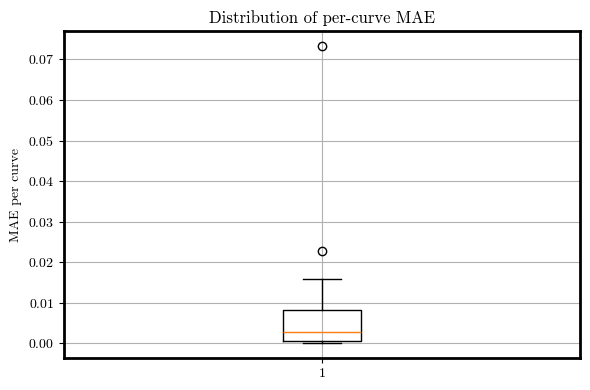

In [129]:
import numpy as np

# Shape: (n_samples, n_timepoints)
errors = Y_pred - Y_test
mae_per_curve = np.mean(np.abs(errors), axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(mae_per_curve, vert=True)
plt.ylabel('MAE per curve')
plt.title('Distribution of per-curve MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


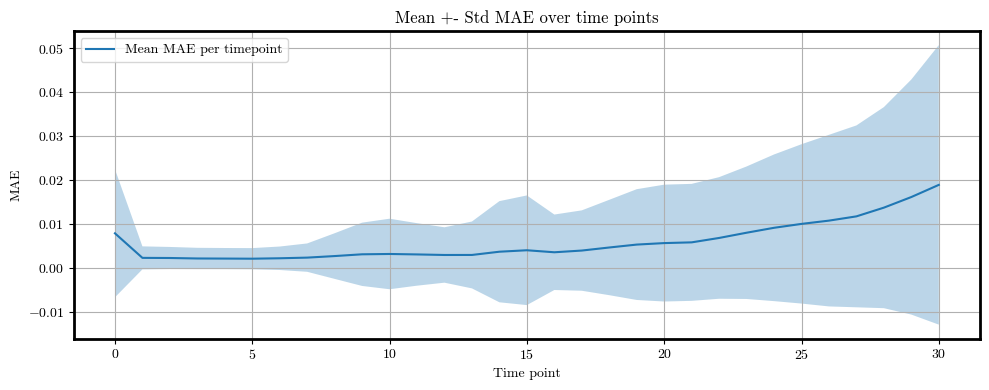

In [131]:
mae_per_t = np.mean(np.abs(errors), axis=0)
std_per_t = np.std(np.abs(errors), axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mae_per_t, label='Mean MAE per timepoint')
plt.fill_between(range(len(mae_per_t)), mae_per_t - std_per_t, mae_per_t + std_per_t, alpha=0.3)
plt.xlabel('Time point')
plt.ylabel('MAE')
plt.title('Mean +- Std MAE over time points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


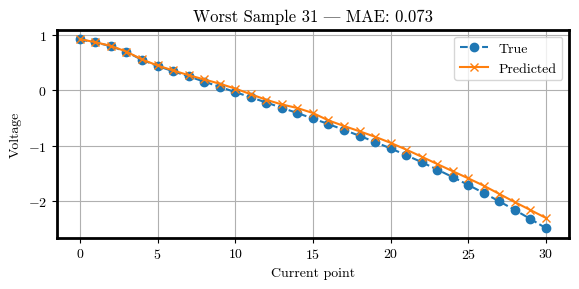

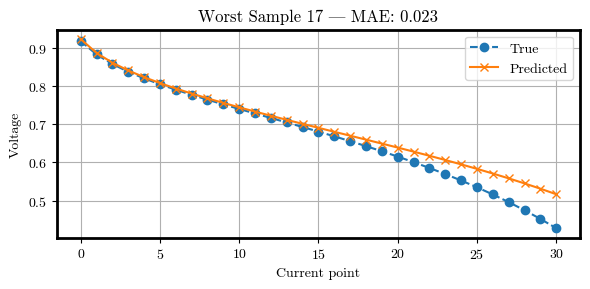

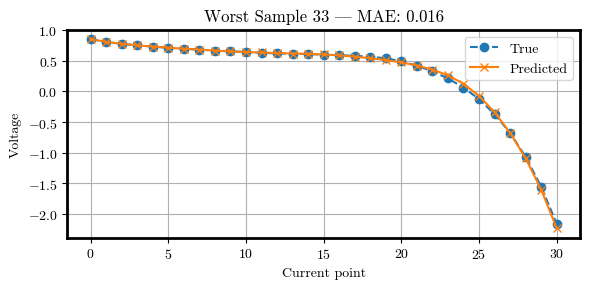

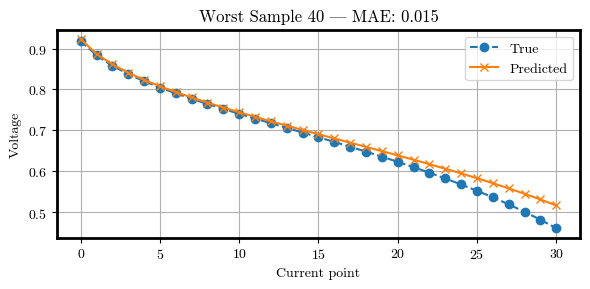

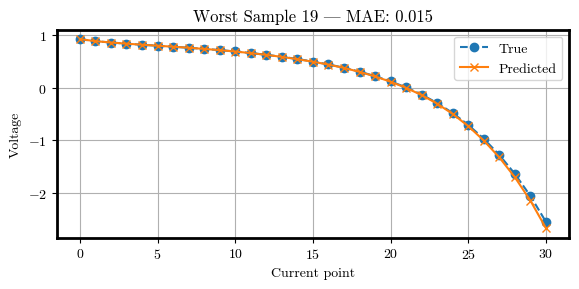

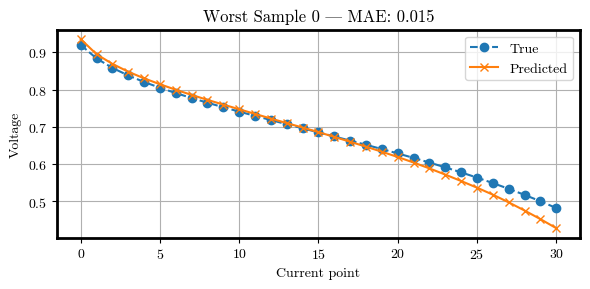

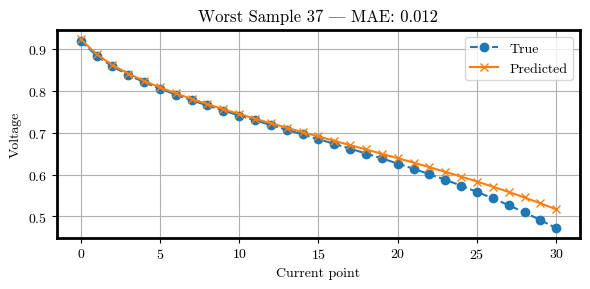

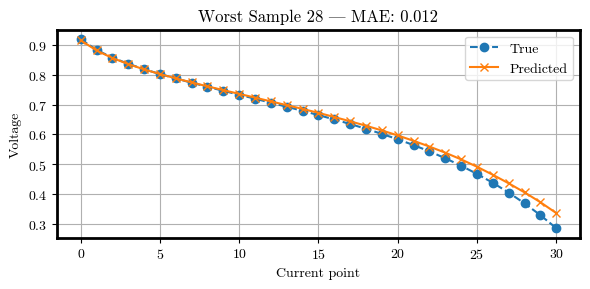

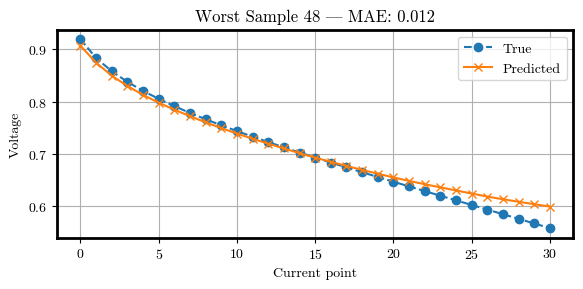

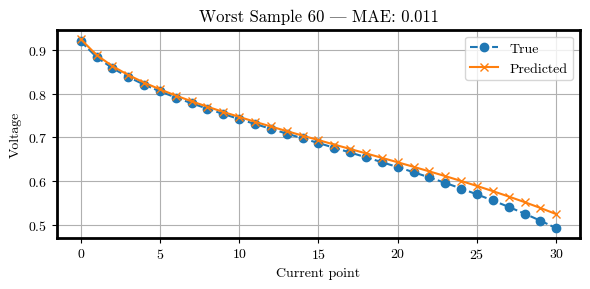

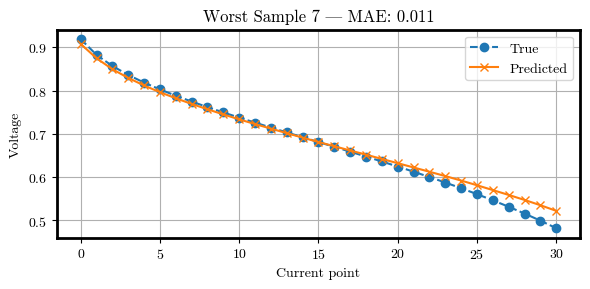

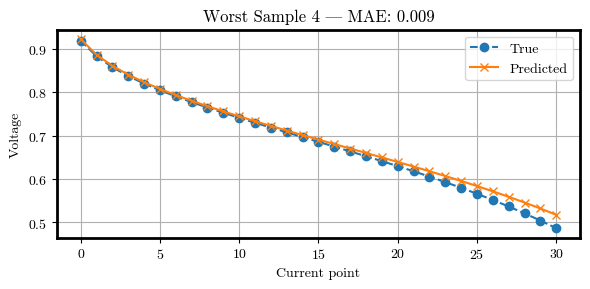

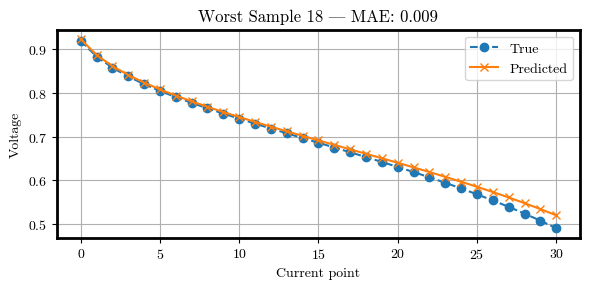

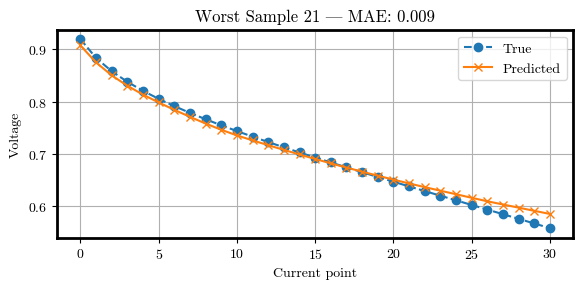

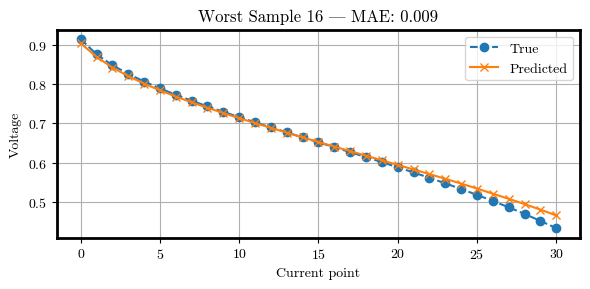

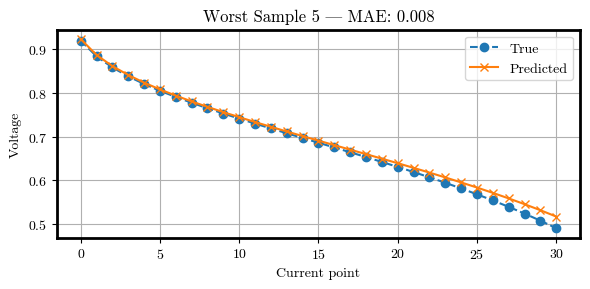

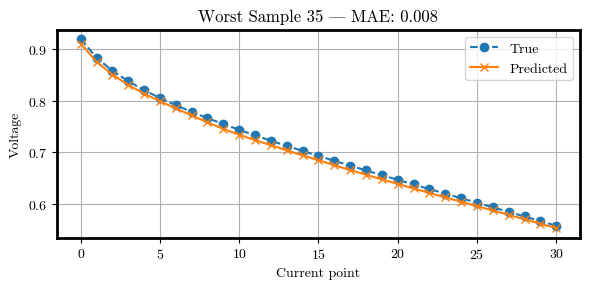

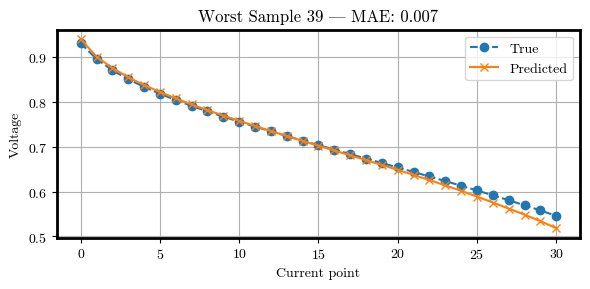

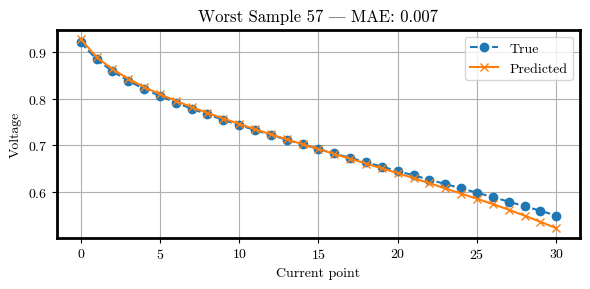

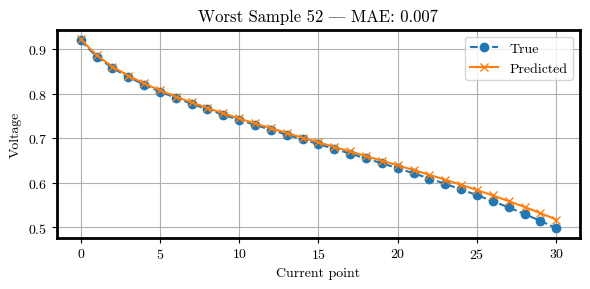

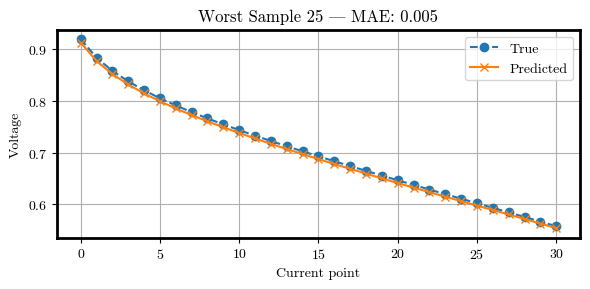

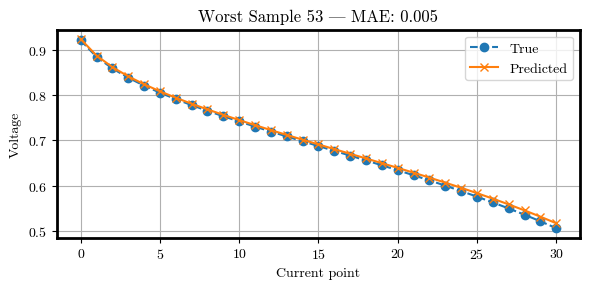

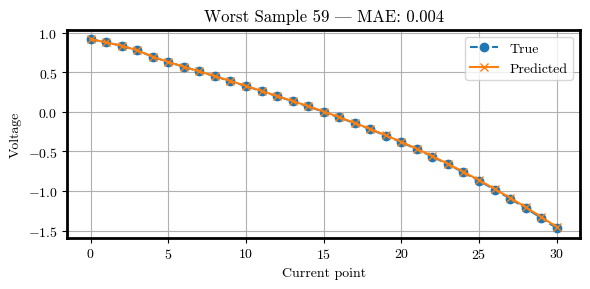

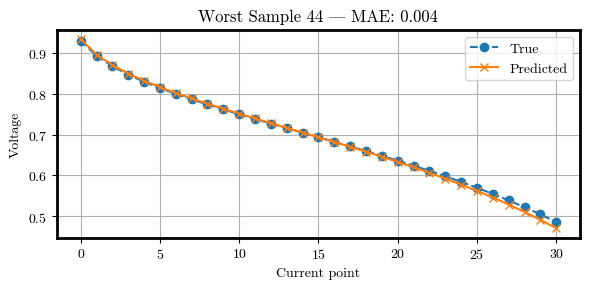

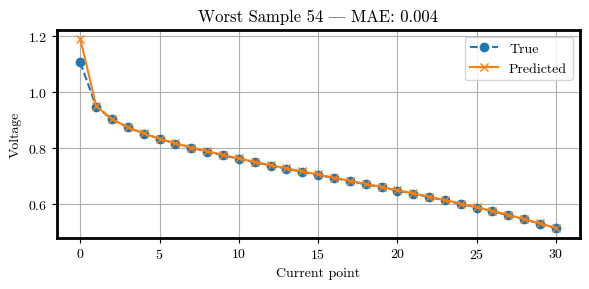

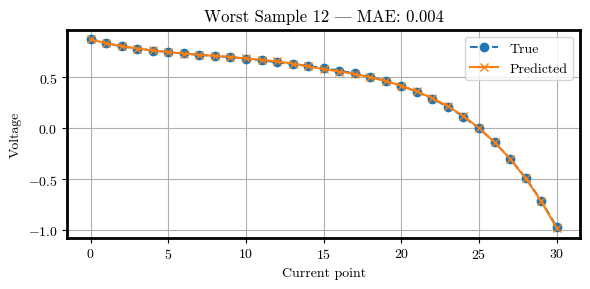

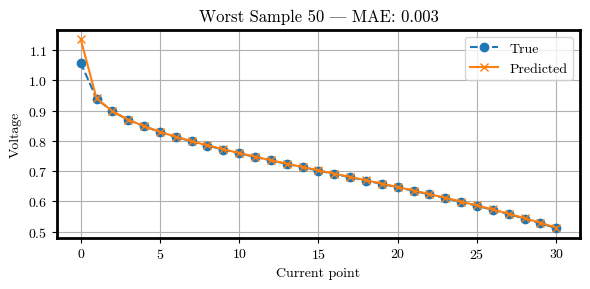

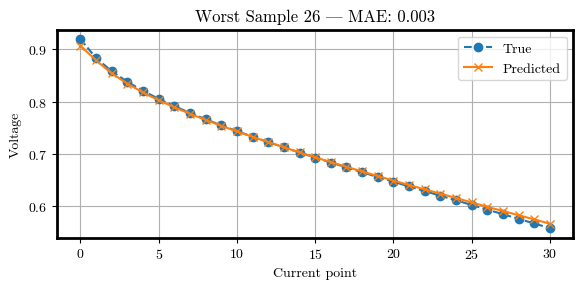

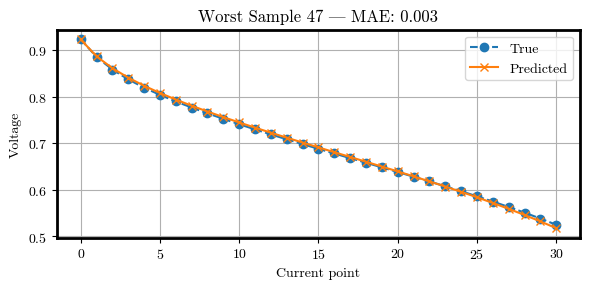

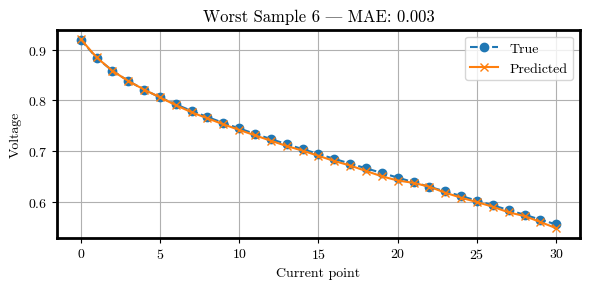

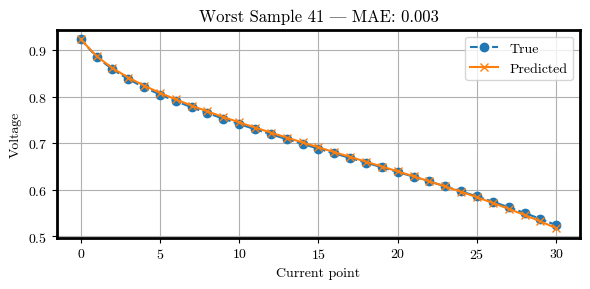

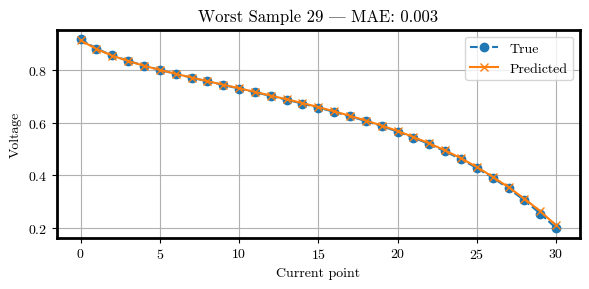

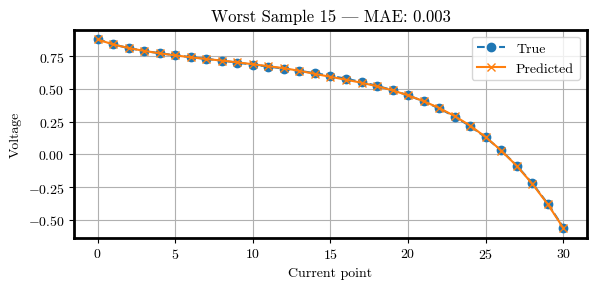

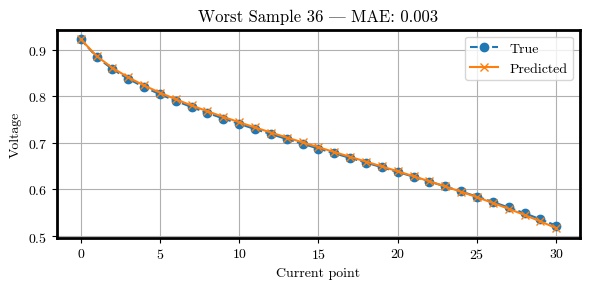

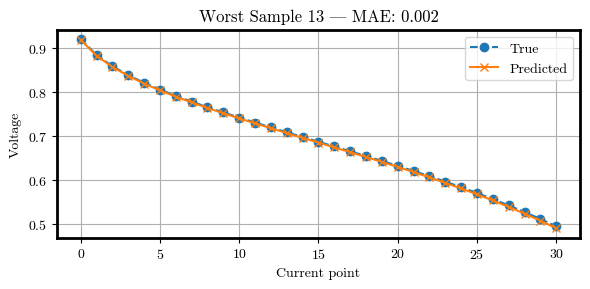

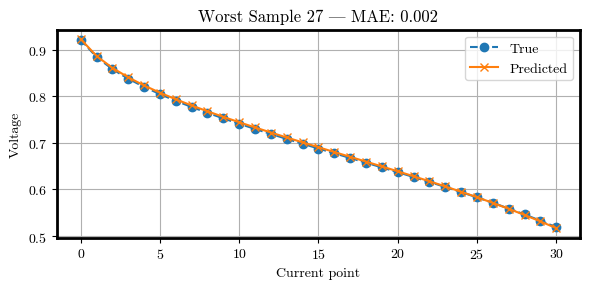

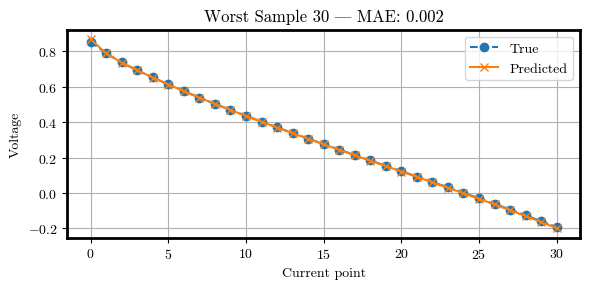

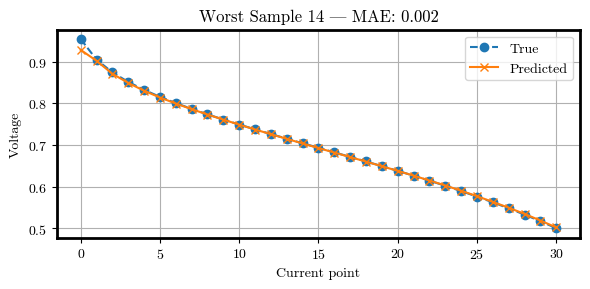

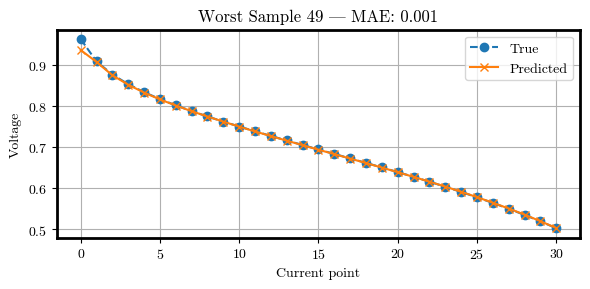

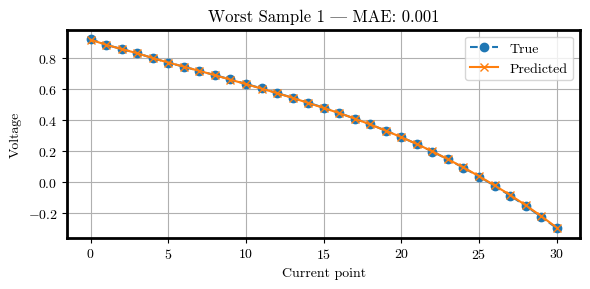

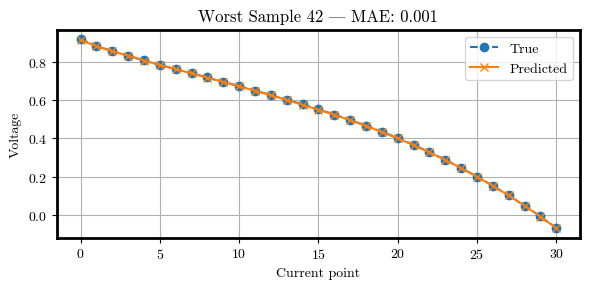

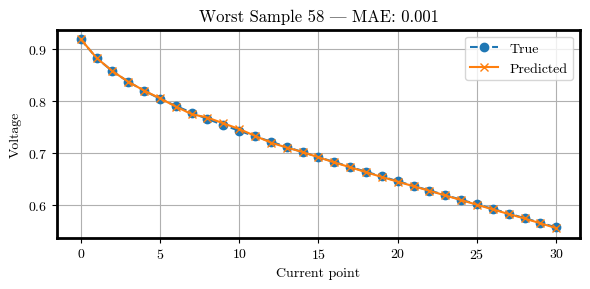

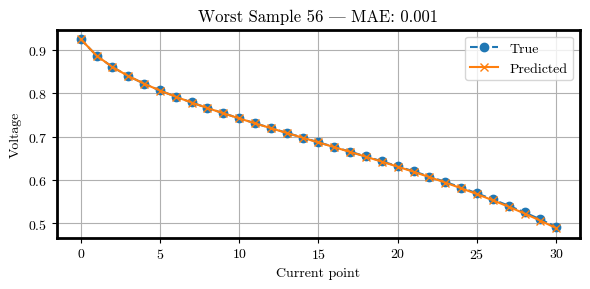

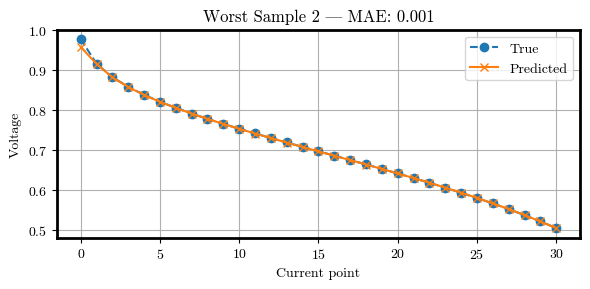

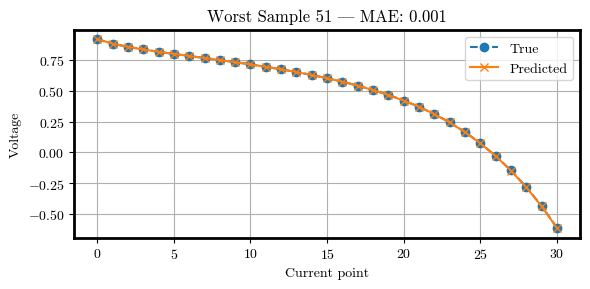

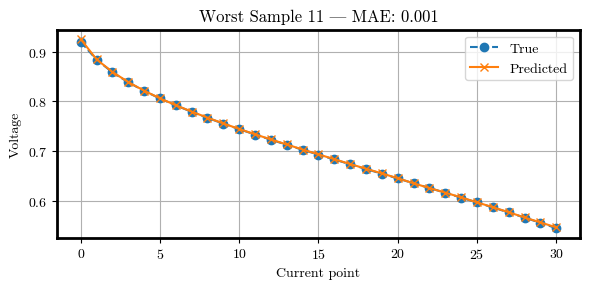

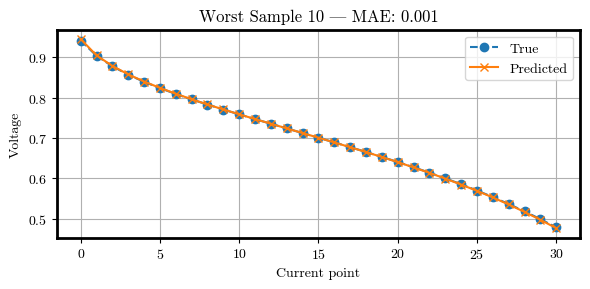

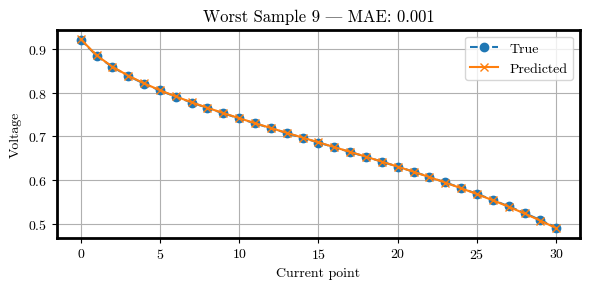

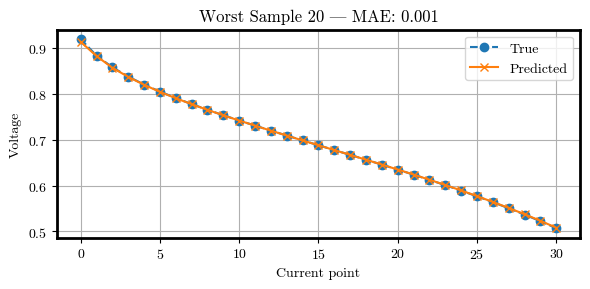

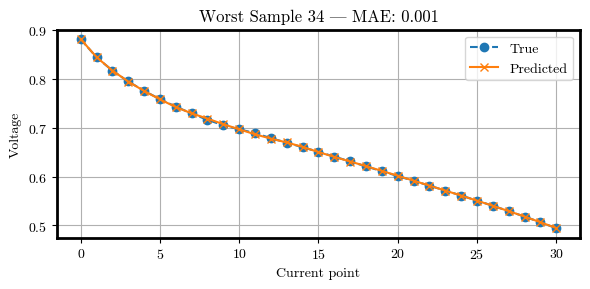

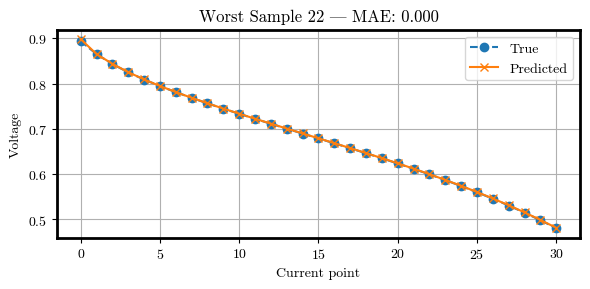

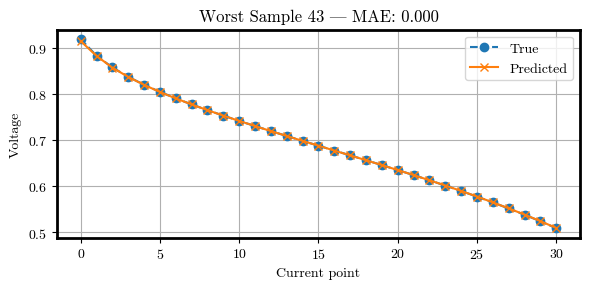

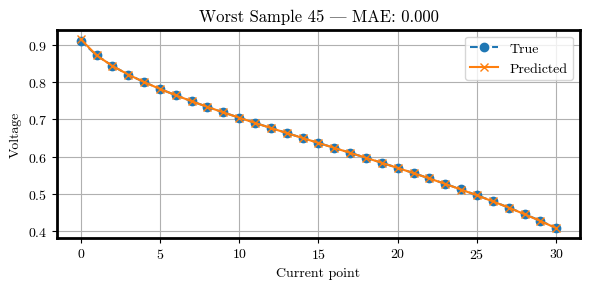

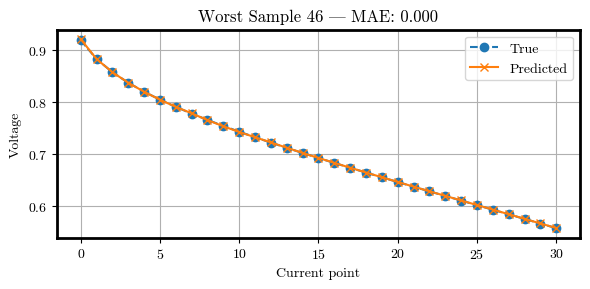

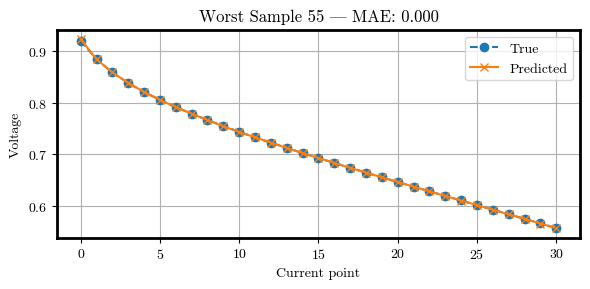

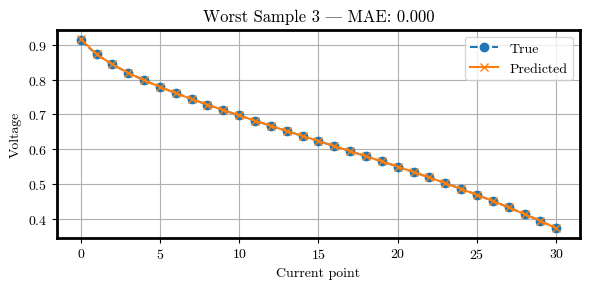

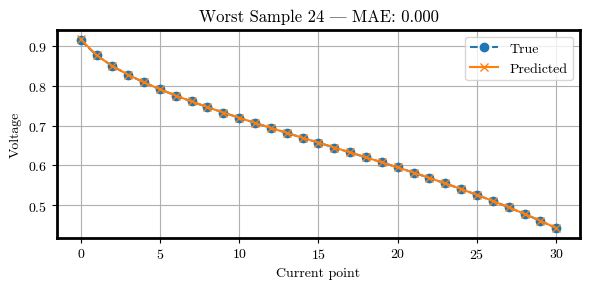

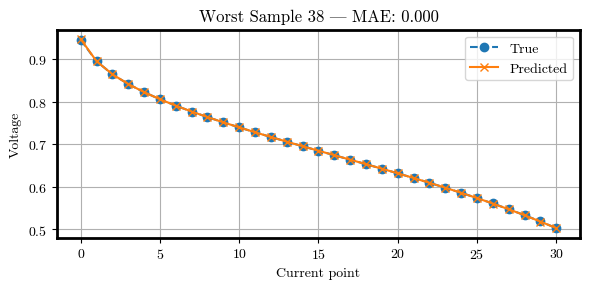

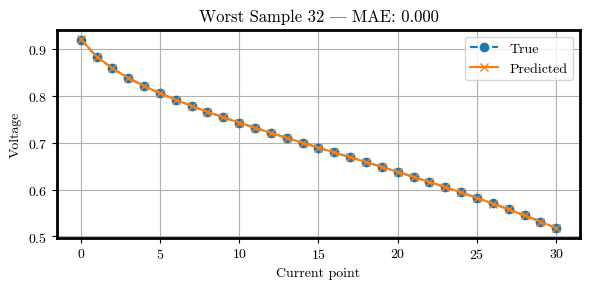

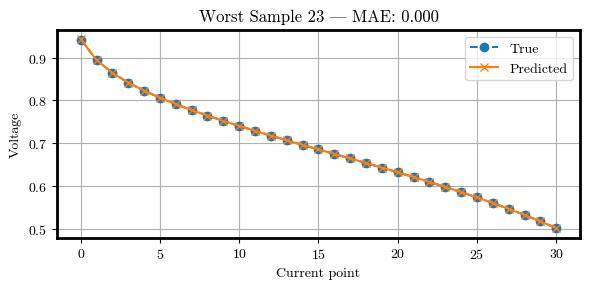

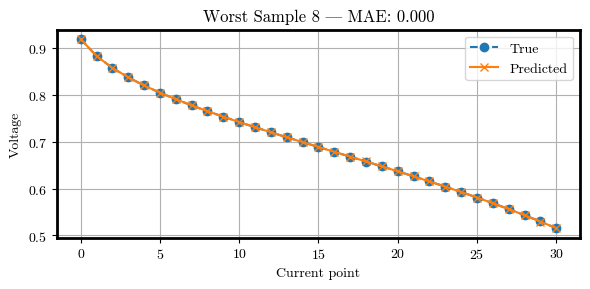

In [132]:
# Indices of the 5 worst curves
worst_indices = np.argsort(mae_per_curve)[0:]

for idx in worst_indices[::-1]:
    plt.figure(figsize=(6, 3))
    plt.plot(Y_test[idx], label='True', linestyle='--', marker='o')
    plt.plot(Y_pred[idx], label='Predicted', marker='x')
    plt.title(f'Worst Sample {idx} | MAE: {mae_per_curve[idx]:.3f}')
    plt.xlabel('Current point')
    plt.ylabel('Voltage')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
